In this version we control the nonlinear dynamics by an open loop.  

Solver is optimize-then-discretize. 

Only consider control constraint.

In [1]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import controller
import matplotlib.pyplot as plt

In [2]:
def Q(t):
    result = np.array(
    [
        [0,0,0,0],
        [0,30.,0,0],
        [0,0,1.,0],
        [0,0,0,1]
    ]
    )
    return result
    
def R(t):
    result = 0.1*np.eye(2)
    return result
#R constructed by scale factor?

'''R = np.array([
    [1/2,0],[0,1/(0.2)]
])
R_scaler = 1. 
R *= R_scaler'''
F = np.array(
    [
        [0,0,0,0],
        [0,30.,0,0],
        [0,0,1.,0],
        [0,0,0,1]
    ]
)


In [3]:
CL = 4.5
''' 
x: x,y,theta,v 
u: T,delta

'''
def f(x,u):
    return np.array([
        [(np.cos(x[2])*x[3])[0]],
        [(np.sin(x[2])*x[3])[0]],
        [((np.tan(u[1])/CL)*x[3])[0]],
        [(0.5*u[0])[0]]
    ])

def nabla_x_f(x,u):
    return np.array([
        [0,0,(-np.sin(x[2])*x[3])[0],(np.cos(x[2]))[0]],
        [0,0,(np.cos(x[2])*x[3])[0],(np.sin(x[2]))[0]],
        [0,0,0,(np.tan(u[1])/CL)[0]],
        [0,0,0,0]
    ])

def nabla_x_phi(x,xd,u):
    return 2*F@(x-xd)

def nabla_x_l(x,xd,u,t):
    return 2*Q(t)@(x-xd)

def nabla_u_l(x,u,t):
    return 2*R(t)@u

def nabla_u_f(x,u):
    return np.array(
        [
        [0,0],
        [0,0],
        [0, (x[3]/(np.cos(u[1])**2 * CL))[0]],
        [0.5,0]
        ]
    )


In [4]:
def forward_integrator(x0,u,time_stops):
    x_list = [x0]
    for i in range(len(time_stops)-1):
        x_list.append(x_list[i] + f(x_list[i],u[i])*(time_stops[i+1]-time_stops[i]))
    return x_list

def backward_integrator(n_x_phi,n_x_f,n_x_l,x,xd,u,time_stops):
    p_list = [n_x_phi(x[-1],xd[-1],u[-1])]
    for i in range(len(time_stops)-1,0,-1):
        p_list.append(
            p_list[-1] + (time_stops[i]-time_stops[i-1]) * (n_x_f(x[i],u[i]).T @ p_list[-1] + n_x_l(x[i],xd[i],u[i],time_stops[i]))
            )
    p_list.reverse()
    return p_list

def grad(x,u,p,n_u_l,n_u_f,time_stops):
    gd = []
    
    for i in range(len(x)):
        gd.append(n_u_l(x[i],u[i],time_stops[i])+n_u_f(x[i],u[i]).T @ p[i])
    
    return gd 

def grad_norm(gd,time_steps):
    norm = 0
    for i in range(len(gd)-1):
        norm += (time_steps[i+1]-time_steps[i])*((np.linalg.norm(gd[i])**2+np.linalg.norm(gd[i+1])**2)/2)
    return np.sqrt(norm)

def project_const(u,constraints):
    u_new = [np.clip(u[i],constraints[i][0],constraints[i][1]) for i in range(len(u))]
    return np.array(u_new).reshape(-1,1)

def projected_grad_descent(u_old,grad,stepsize,u_constraints):
    ''' 
    constraints:[[lower,upper],[lower,upper],...]
    '''
    u_new = []
    for i in range(len(u_old)):

        u_new.append(project_const(u_old[i]-stepsize*grad[i],u_constraints))
    return u_new 

In [5]:

x0 = np.array(
    [
        [0],
        [3.],
        [0],
        [10]
    ]
)

xd = np.array(
    [
        [0],
        [0.],
        [0],
        [10]
    ]
)

u0 = np.array(
    [
        [0],
        [0]
    ]
)

In [6]:
dt = 0.02
pred_horizon = [0,10]
disc_steps = 2000
time_stops = np.linspace(pred_horizon[0],pred_horizon[1],disc_steps)

In [7]:

def pgd_solve(grad_tolerance=1e-6,max_iter=100):
    iter = 0 
    gd_norm = 1.
    xd_bar = [xd for i in range(disc_steps)]
    u_bar = [u0 for i in range(disc_steps)]
    while iter < max_iter and gd_norm > grad_tolerance:
        x_bar = forward_integrator(x0,u_bar,time_stops)
        p_bar = backward_integrator(nabla_x_phi,nabla_x_f,nabla_x_l,x_bar,xd_bar,u_bar,time_stops)

        grad_bar = grad(x_bar,u_bar,p_bar,n_u_f = nabla_u_f,n_u_l=nabla_u_l,time_stops = time_stops)
        
        
        u_bar = projected_grad_descent(u_bar,grad_bar,0.00001,[[-1.0,1.0],[-np.pi/3,np.pi/3]])
        iter += 1
        gd_norm = grad_norm(grad_bar,time_stops)
        print('PGD at iteration: {}, grad_norm: {}'.format(iter,gd_norm))

    return u_bar,x_bar 

In [8]:
ub,xb = pgd_solve()

PGD at iteration: 1, grad_norm: 353845.5604978007
PGD at iteration: 2, grad_norm: 723912.6362289932
PGD at iteration: 3, grad_norm: 468769.4612080814
PGD at iteration: 4, grad_norm: 813978.6189135312
PGD at iteration: 5, grad_norm: 39814.25147545225
PGD at iteration: 6, grad_norm: 138077.01858417632
PGD at iteration: 7, grad_norm: 176363.1421710854
PGD at iteration: 8, grad_norm: 691250.4193231625
PGD at iteration: 9, grad_norm: 2092321.3722757385
PGD at iteration: 10, grad_norm: 257699.49035480325
PGD at iteration: 11, grad_norm: 1106674.551861669
PGD at iteration: 12, grad_norm: 816678.5504182347
PGD at iteration: 13, grad_norm: 264723.8819614016
PGD at iteration: 14, grad_norm: 87338.71531796912
PGD at iteration: 15, grad_norm: 216139.844083838
PGD at iteration: 16, grad_norm: 462889.7798648114
PGD at iteration: 17, grad_norm: 93898.10840321361
PGD at iteration: 18, grad_norm: 334269.61587175226
PGD at iteration: 19, grad_norm: 84411.38990963572
PGD at iteration: 20, grad_norm: 4223

In [9]:
xm = np.array(xb).squeeze(-1)
print(xm.shape)

(2000, 4)


In [10]:
u_tilde = np.array(ub).squeeze(-1)

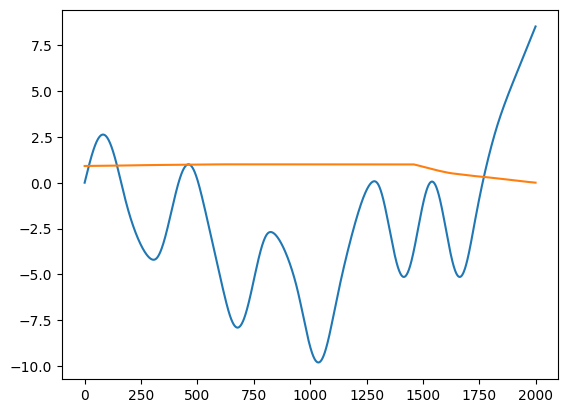

In [11]:
plt.plot(xm[:,0])
plt.plot(u_tilde[:,0])

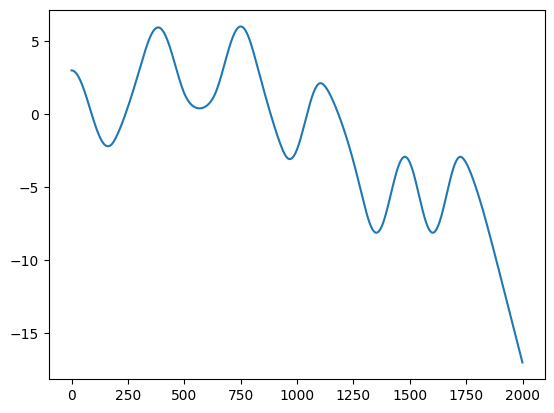

In [12]:
plt.plot(xm[:,1])

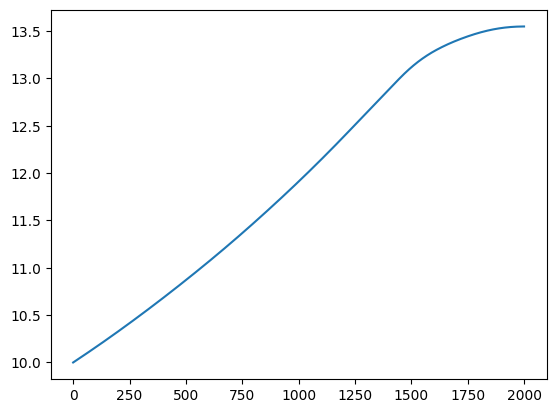

In [13]:
plt.plot(xm[:,3])

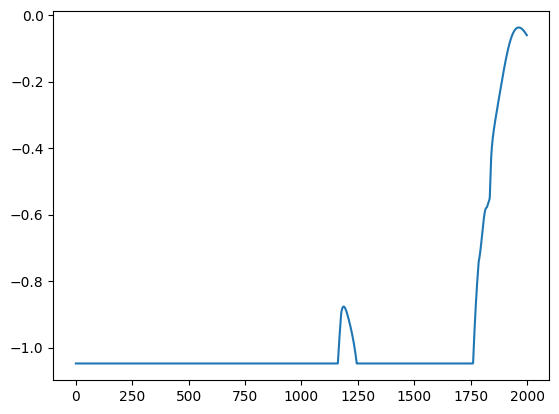

In [14]:
plt.plot(u_tilde[:,1])

In [15]:
u_tilde[6,0]

0.912574350883864